In [3]:
!pip install basemap pyproj matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: pyshp
    Found existing installation: pyshp 3.0.2.post1
    Uninstalling pyshp-3.0.2.post1:
      Successfully uninstalled pyshp-3.0.2.post1


**Import Libraries**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Load Data**

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/database.csv")
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]

import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d + ' ' + t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')

data['Timestamp'] = pd.Series(timestamp)
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError'].copy()
final_data['Timestamp'] = pd.to_numeric(final_data['Timestamp'])

**Visualize Data**

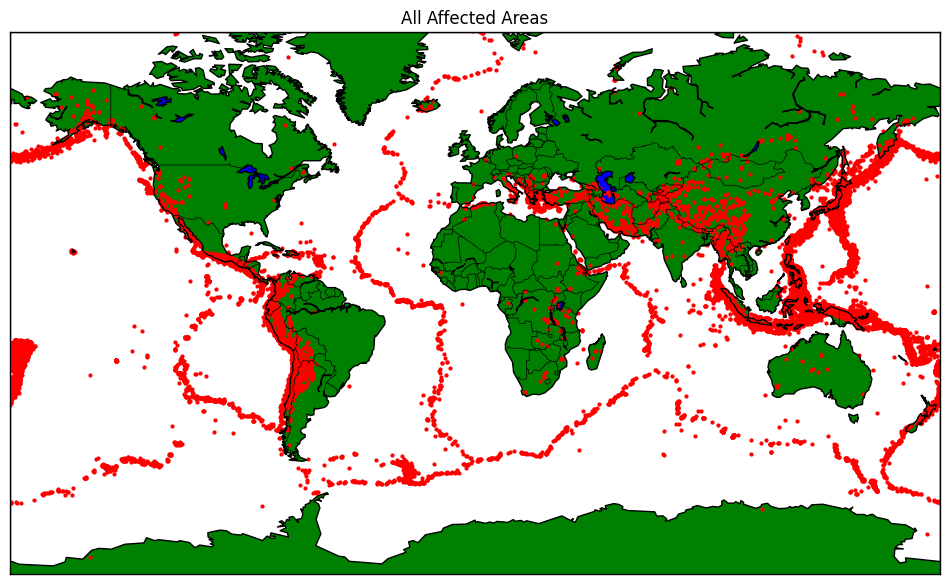

In [7]:
m = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80,
            llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()

x, y = m(longitudes, latitudes)

fig = plt.figure(figsize=(12, 10))
plt.title("All Affected Areas")
m.plot(x, y, "o", markersize=2, color='red')
m.drawcoastlines(color='black')
m.fillcontinents(color='green', lake_color='blue')
m.drawmapboundary(color='k')
m.drawcountries(color='black')
plt.show()

**Prepare Data**

In [8]:
x = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Depth', 'Magnitude']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

**Define Model**

In [9]:
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='linear')
])

**Compile and Train**

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8893.2637 - mean_absolute_error: 34.5662 - val_loss: 7383.7485 - val_mean_absolute_error: 34.3879 - learning_rate: 0.0010
Epoch 2/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7384.3652 - mean_absolute_error: 35.3868 - val_loss: 7302.5649 - val_mean_absolute_error: 35.7186 - learning_rate: 0.0010
Epoch 3/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7242.5986 - mean_absolute_error: 35.2607 - val_loss: 7220.9736 - val_mean_absolute_error: 34.7274 - learning_rate: 0.0010
Epoch 4/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7264.5820 - mean_absolute_error: 34.9301 - val_loss: 7111.2397 - val_mean_absolute_error: 33.8249 - learning_rate: 0.0010
Epoch 5/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7025.2583 - mean_absolute_error: 34.3323 - val_loss: 7023.6753 - val_mean_absolute_error: 32.1699 - learning_rate: 0.0010
Epoch 6/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6975.9287 - mean_absolut

**Evaluate Model**

In [11]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print(f"Test MSE: {loss:.4f} | Test MAE: {mae:.4f}")

Test MSE: 5056.7798 | Test MAE: 28.5742


**Make Predictions**

In [12]:
y_pred = model.predict(x_test)
print("Sample predictions:")
print(pd.DataFrame(y_pred[:5], columns=['Predicted Depth', 'Predicted Magnitude']))

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Sample predictions:
   Predicted Depth  Predicted Magnitude
0        72.596725             5.913070
1        74.906578             5.927969
2       173.670547             5.874537
3        72.974060             5.992325
4        23.033075             5.841696


**Plot Training History**

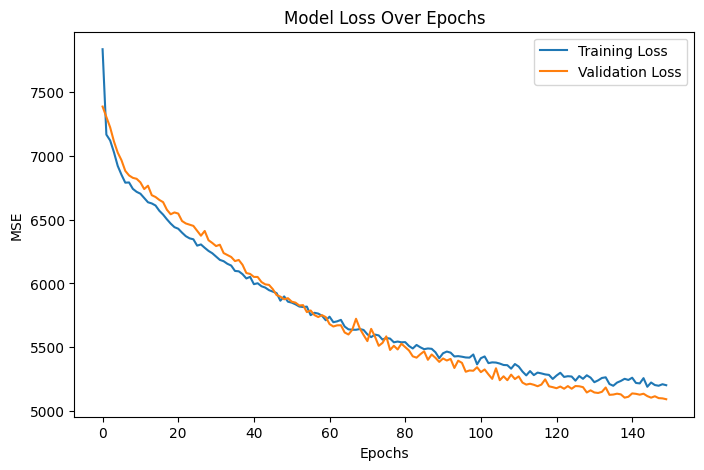

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()